# Lecture 9 - Uncertainty Propagation: Advanced Monte Carlo Sampling

## Objectives

+ To use importance sampling to accelerate MC
+ To use latin hyper-cube designs to accelerate MC in moderate dimensions
+ To propagate uncertainty through an initial value problem

## Readings

+ These notes.
+ Monte Carlo Strategies in Scientific Computing (Jun S. Liu, 2001): Chapters 1 and 2.
+ Monte Carlo Statistical Methods (Christian P. Robert and George Casella, 1999): Chapter 3.
+ McKay, M.D.; Beckman, R.J.; Conover, W.J. (May 1979). A Comparison of Three Methods for Selecting Values of Input Variables in the Analysis of Output from a Computer Code. Technometrics (JSTOR Abstract) (American Statistical Association) 21 (2): 239–245. doi:10.2307/1268522. ISSN 0040-1706. JSTOR 1268522. OSTI 5236110

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

## Importance Sampling
Let $X$ be a random variable with probability density $p(x)$ and $f(x)$ be a function.
As in the lecture 13, we wish to estimate the expectation:
$$
I = \mathbb{E}_p[f(X)]=\int f(x)p(x)dx.
$$
Note that we have explicitly marked the expectation operator with $p$.
This is because in a while we will change $p$ to something else.

The idea in *importance sampling* is to re-write $I$ as an expectation with respect to another probability density, say $q(x)$.
The only requirement is that the support of $q(x)$ must be broader than the support of $p(x)$ ($q(x)$ must be positive wherever $p(x)$ is positive).
Here we go:
$$
I = \mathbb{E}_p[f(X)] = \int f(x)p(x)dx = \int \frac{f(x)p(x)}{q(x)}q(x)dx = \mathbb{E}_q\left[\frac{f(x)p(x)}{q(x)}\right].
$$
This suggests that you can estimate $I$ by sampling from $q(x)$ instead of $p(x)$.
A trivial estimator is:
$$
I_{n} = \frac{1}{n}\sum_{j=1}^n\frac{f(X_j)p(X_j)}{q(X_j)}, 
$$
where $X_1,\dots,X_n\sim q$ iid.

Why on earth is this useful?

+ First, it may be much easier to sample from $q(x)$ than it is to sample from $p(x)$.
+ You can reuse samples from $q(x)$ with different $f(x)$ and different $p(x)$.
+ With the right choice of $q(x)$ you can actually reduce the variance of the MC estimator.

Let's see how it works in practice.

### Example: Small Tail Probabilities (Casella 3.11)
Let $X\sim \mathcal{N}(0,1)$ and assume that we want to compute:
$$
I = \mathbb{P}[X > 4.5].
$$
The standard MC estimator is:
$$
I_n = \frac{1}{n}\sum_{j=1}^n1_{[4.5,+\infty]}(X_j),
$$
for $X_j\sim \mathcal{N}(0,1)$ iid.
Let's see how it does.

In [2]:
num_mc = 10000
s = 0.
s2 = 0.
for i in range(num_mc):
    x = np.random.randn()
    if x > 4.5:
        s += 1.
        s2 += 1.
I_n = s / num_mc
V_n = (s2 / num_mc - I_n ** 2) / num_mc
print('I_n = %1.2e +- %1.2e' % (I_n, 2 * np.sqrt(V_n)))

I_n = 0.00e+00 +- 0.00e+00


It doesn't look right for $n=10,000$. We did not count a single event. You would have to go to $n=1,000,000$ to hit one or two events.
To get an accurate answer you probably need hundrends of millions of samples.

Let's see if we can remedy this situtation with importance sampling.
Ideally, we only want to sample $X$'s that are greater than $4.5$.
Let us introduce a random variable $Y\sim \mathcal{TE}(4.5, 1)$ following an exponential distribution with rate parameter $1$ which is truncated at $4.5$.
The density of $Y$ is:
$$
q(y) = \frac{e^{-y}}{c}1_{[4.5,+\infty)}(y),
$$
where $c$ is a normalization constant.
To find the normalization constant we impose:
$$
\int q(y) dy = 1 \Rightarrow c = \int_0^{+\infty}e^{-y}1_{[4.5,+\infty)}(y)dy = \int_{4.5}^{+\infty}e^{-y}dy = \left[-e^{-y}\right]_{4.5}^{+\infty}=e^{-4.5}.
$$
So, the density becomes:
$$
q(y) = e^{-(y-4.5)}1_{[4.5,+\infty)}(y).
$$
Let's visualize it comparing it to the standard normal.

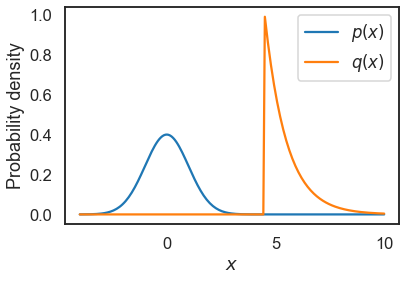

In [3]:
fig, ax = plt.subplots()
x = np.linspace(-4., 10., 200)
p = st.norm.pdf(x)
q = np.exp(-(x-4.5))
q[x < 4.5] = 0.
ax.plot(x, p, label='$p(x)$')
ax.plot(x, q, label='$q(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('Probability density')
plt.legend(loc='best');

The importance sampling estimator is:
$$
I_{2,n} = \frac{1}{n}\sum_{j=1}^n\frac{f(X_j)p(X_j)}{q(X_j)}=\frac{1}{n\sqrt{2\pi}}\sum_{j=1}^ne^{-\frac{1}{2}X_j^2+X_j-4.5},
$$
for $X_1,\dots,X_n\sim q$ iid.
Let's see what we are going to get:

In [4]:
num_mc = 10000
s = 0.
s2 = 0.
for i in range(num_mc):
    x = np.random.exponential() + 4.5 # Just add 4.5 to a standard exponential
    f = np.exp(-0.5 * x ** 2 + x - 4.5) / np.sqrt(2. * np.pi)
    s += f
    s2 += f ** 2
I_n = s / num_mc
V_n = (s2 / num_mc - I_n ** 2) / num_mc
print('I_n = %1.4e +- %1.4e' % (I_n, 2*np.sqrt(V_n)))

I_n = 3.3932e-06 +- 8.7954e-08


### Finite variance concerns
The variance of an importance sampling estimator is:
$$
V_n = \mathbb{V}[I_n] = \frac{1}{n}\mathbb{V}_q\left[\frac{f(X_j)p(X_j)}{q(X_j)}\right]=\frac{1}{n}\left(\mathbb{E}_q\left[\frac{f^2(X_j)p^2(X_j)}{q^2(X_j)}\right]-\left(\mathbb{E}_q\left[\frac{f(X_j)p(X_j)}{q(X_j)}\right]\right)^2\right).
$$
So, in order to have a finite variance estimator, we must have that:
$$
\mathbb{E}_q\left[\frac{f^2(X_j)p^2(X_j)}{q^2(X_j)}\right] = \int f^2(x)\frac{p^2(x)}{q(x)}dx < \infty.
$$
Unless, this condition is satisfied, you will get garbage.

### Example: Infinite Variance Estimator.
It is absolutely crucial that the variance of your estimator is finite.
Otherwise, you cannot trust it even if it theoretically converges.
Let us demonstrate this by constructing a really stupid importance sampling desnity.
Let $X\sim\mathcal{E}(1)$ (exponential with unit rate) so that the density is:
$$
p(x) = e^{-x}_{[0,\infty)}(x).
$$
Pick $f(x)=x$ so that we want to compute the mean $\mathbb{E}[f(X)] = \mathbb{E}_p[X]=1$ (analytically known).
As importance sampling density let's use the density of a $\mathcal{N}(0,1)$:
$$
q(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}.
$$
Let's look at that integral that dominates the variance:
$$
\int f^2(x)\frac{p^2(x)}{q(x)}dx = \int_0^\infty x^2 \frac{e^{-2x}}{\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}}dx = \infty.
$$
Let's implement an MC estimate using this importance sampling density and see what we get.

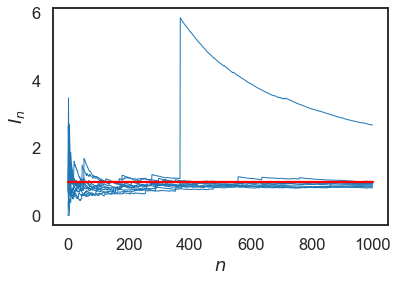

In [5]:
# How many times to try
num_tries = 10
# How many MC steps to take per try 
num_mc = 1000
# For plotting purposes
fig, ax = plt.subplots()
for i in range(num_tries):
    I = np.ndarray((num_mc, ))
    s = 0.
    for j in range(num_mc):
        x = np.random.randn()
        if x >= 0.:
            y = x * np.exp(-x) / st.norm.pdf(x)
            s += y
        I[j] = s / (j + 1)
    plt.plot(np.arange(1, num_mc + 1), I, color=sns.color_palette()[0], lw=1)
ax.set_xlabel('$n$')
ax.set_ylabel('$I_n$')
plt.plot(np.arange(1, num_mc + 1), np.ones((num_mc, )), color='r');

### Questions

+ Do a single trial for a large number of samples. Does it converge? Remember, that in reality you never know the truth (red line). If you think that you have found a number of samples that guarantees convergence, run it once more. Does it converge now?

+ Increase the number of tries to 10, 100, 1000 (decrease the number of samples per trial if it becomes to slow). What do you observe?

### The Best Importance Sampling Distribution
So, the choice of $q(x)$ is completely up to us.
What if we picked it so that we minimize the variance of the estimator?
That is, we would like to find the $q^*(x)$ that solves minimizes:
$$
\min_{q}\int f^2(x)\frac{p^2(x)}{q(x)}dx.
$$
We will do it by taking the derivative of the functional:
$$
J[q] = \int f^2(x)\frac{p^2(x)}{q(x)}dx,
$$
with respect to an arbitrary direction and setting it equal to zero.
To this end, let $\eta(x)$ be any non-negative function such that
$$
\int \eta(x)dx = 0.
$$
Then, for any $\epsilon>0$, we have that the pertubation $q(x) + \epsilon\eta(x)$ is a valid probability density since:
$$
\int (q(x) + \epsilon\eta(x)) dx = \int q(x) dx + \epsilon\int\eta(x)dx = 1.
$$
The first variation of $J[q]$ in the direction of $\eta(x)$ is:
$$
\begin{split}
\frac{\delta J[q]}{\delta \eta} &= \lim_{\epsilon\rightarrow 0}\frac{J[q + \epsilon\eta]-J[q]}{\epsilon}\\
&= \lim_{\epsilon\rightarrow 0}\frac{\int \left[f^2(x)\frac{p^2(x)}{q(x)+\epsilon\eta(x)}-f^2(x)\frac{p^2(x)}{q(x)}\right]dx}{\epsilon}\\
&= \lim_{\epsilon\rightarrow 0}\frac{\int f^2(x)p^2(x)\left[\frac{1}{q(x)+\epsilon\eta(x)}-\frac{1}{q(x)}\right]dx}{\epsilon}\\
&= \lim_{\epsilon\rightarrow 0}\frac{\int f^2(x)p^2(x)\left[\frac{q(x)-q(x)-\epsilon\eta(x)}{\left(q(x)+\epsilon\eta(x)\right)q(x)}\right]dx}{\epsilon}\\
&=-\lim_{\epsilon\rightarrow 0}\int f^2(x)p^2(x)\left[\frac{\eta(x)}{\left(q(x)+\epsilon\eta(x)\right)q(x)}\right]dx\\
&=-\int f^2(x)p^2(x)\left[\frac{\eta(x)}{q^2(x)}\right]dx.
\end{split}
$$
For an extremum, the first variation must be equal to zero (necessary condition) for all possible $\eta$'s.
We see that this is trivially satisfied for:
$$
q^*(x) \propto |f(x)|p(x).
$$
To show that the above defined $q^*$ is a minimum, we need to take the second variation of $J[q]$ and show that it is positive for all $\eta$'s.
We leave this as an excersise.

### Questions

+ Is it really possible to use the minimum variance importance sampling density? 

## Latin Hyper-Cube Designs

Latin hyper-cube designs (LHS) are quasi-random sequences that resemble uniform random nummbers, but have better convergence properties than truly random numbers.

+ A **latin square** is a square grid containing samples only one sample in each row and each column.
+ A **latin hypercube** is the generalisation of this concept to many dimensions.

Here is how they look like in 2D.

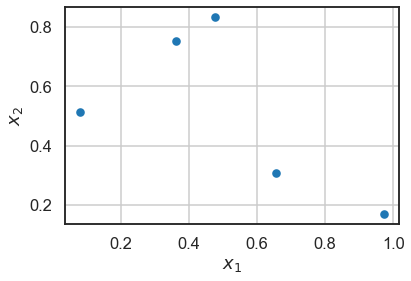

In [7]:
import pyDOE # Library the implements latin hyper-cube designs you must install it: pip install py-design
fig, ax = plt.subplots()
ax.grid(which='major')
for i in range(1):
    X = pyDOE.lhs(2, 5) # 2 is the dimension, 5 is the number of samples, 
    ax.scatter(X[:,0], X[:,1], 50., color=sns.color_palette()[i])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Let's compare to uniform samples in 2D:

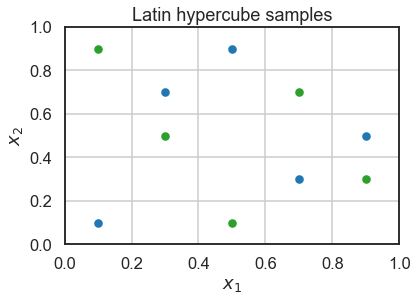

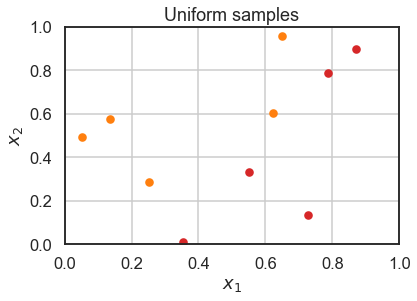

In [8]:
num_samples = 5
fig, ax = plt.subplots()
X_lhs = pyDOE.lhs(2, num_samples, 'c')
ax.scatter(X_lhs[:,0], X_lhs[:,1], 50., color=sns.color_palette()[0])
X_lhs = pyDOE.lhs(2, num_samples, 'c')
ax.grid(which='major')
ax.scatter(X_lhs[:,0], X_lhs[:,1], 50., color=sns.color_palette()[2])
ax.set_title('Latin hypercube samples')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');
fig2, ax2 = plt.subplots()
X_unif = np.random.rand(num_samples, 2)
ax2.grid(which='major')
ax2.scatter(X_unif[:,0], X_unif[:,1], 50., color=sns.color_palette()[1])
X_unif = np.random.rand(num_samples, 2)
ax2.scatter(X_unif[:,0], X_unif[:,1], 50., color=sns.color_palette()[3])
ax2.set_title('Uniform samples')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$');

## Uniform Sampling vs Latin Hyper-cubes
Consider the ODE:
  \begin{align*}
    \dot{y} = \frac{d y(t)}{dt} & =-ay(t),\qquad y(0) = y_0.
  \end{align*}
The solution is: $y(t) = Ie^{-at}$.
Let's make $a$ and $I$ random and use MC and LHS to find the mean, $E[y(t)]$, and the variance $V[y(t)]$.
We'll take:
$$
a \sim \mathcal{U}(0, 0.1),
$$
and
$$
y_0 \sim \mathcal{U}(8, 10).
$$
For convenience, let's map these random variables to standardized uniform random variables:
$$
x_i \sim \mathcal{U}(0, 1), i=1,2.
$$
This can be done by defining:
$$
a = 0.1 x_1.
$$
Using the new random variables, the ODE can be written as:
$$
\dot{y} = -0.1 x_1 y, y(0) = 8 + 2x_2.
$$

### The "Solver" object
Let's develop a solver for this problem. We'll make the solver work as a nice function that accepts a vector $\mathbf{x} = (x_1, x_2)$ as an input, and returns the solution of the ODE on a finite set of timesteps $0=t_1<t_2<\dots<t_{n_t}=T$. The solver, will make use of the functionality of [scipy.integrate.odeint](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.odeint.html). This is a trivial problem, but studying its structure will teach you a few useful Python tricks.

In [9]:
import scipy.integrate

class Ex1Solver(object):
    """
    An object that can solver the afforementioned ODE problem.
    It will work just like a multivariate function.
    """
    
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of timesteps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The timesteps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
    
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 2 elements. This represents the stochastic input x = (x1, x2).
        """
        def rhs(y, t, x1):
            """
            This is the right hand side of the ODE.
            """
            return -.1 * x1 * y
        # The initial condition
        y0 = [8 + 2 * x[1]]
        # We are ready to solve the ODE
        y = scipy.integrate.odeint(rhs, y0, self.t, args=(x[0],)).flatten()
        # The only strange thing here is the use of ``args`` to pass they x1 argument to the rhs().
        # That's it
        return y

Since this is the first time we see a Python class, let's play with it.

In [10]:
# Here is how you can initialize it:
solver = Ex1Solver()
# You can access its arguments:
print("Number of timesteps:", solver.nt)
print("Final time:", solver.T)
print("Timesteps:", solver.t)
print("Num inputs:", solver.num_input)
print("Num outputs:", solver.num_output)

Number of timesteps: 100
Final time: 5
Timesteps: [0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 3.03030303 3.08080808 3.13131313 3.18181818 3.23232323 3.28282828
 3.33333333 3.38383838 3.43434343 3.48484848 3.53535354 3.58585859
 3.63636364 3.68686869 3.73737374 3.78787879 3.83838384 3.88888889
 3.93939394 3.98989899 4.04040404 4.09090909 4.14141414 4.19191919
 4.24242424 

In [11]:
# If you wish, you may intiialize it with a different initial arguments:
solver = Ex1Solver(nt=200, T=50)
print("Number of timesteps:", solver.nt)
print("Final time:", solver.T)
print("Timesteps:", solver.t)
print("Num inputs:", solver.num_input)
print("Num outputs:", solver.num_output)

Number of timesteps: 200
Final time: 50
Timesteps: [ 0.          0.25125628  0.50251256  0.75376884  1.00502513  1.25628141
  1.50753769  1.75879397  2.01005025  2.26130653  2.51256281  2.7638191
  3.01507538  3.26633166  3.51758794  3.76884422  4.0201005   4.27135678
  4.52261307  4.77386935  5.02512563  5.27638191  5.52763819  5.77889447
  6.03015075  6.28140704  6.53266332  6.7839196   7.03517588  7.28643216
  7.53768844  7.78894472  8.04020101  8.29145729  8.54271357  8.79396985
  9.04522613  9.29648241  9.54773869  9.79899497 10.05025126 10.30150754
 10.55276382 10.8040201  11.05527638 11.30653266 11.55778894 11.80904523
 12.06030151 12.31155779 12.56281407 12.81407035 13.06532663 13.31658291
 13.5678392  13.81909548 14.07035176 14.32160804 14.57286432 14.8241206
 15.07537688 15.32663317 15.57788945 15.82914573 16.08040201 16.33165829
 16.58291457 16.83417085 17.08542714 17.33668342 17.5879397  17.83919598
 18.09045226 18.34170854 18.59296482 18.84422111 19.09547739 19.34673367
 1

In [12]:
# Now let's evaluate the solver at a specific input.
# You can just use it as a function
x = [0.5, 0.5]
y = solver(x)
print(y)

[9.         8.88764176 8.77668666 8.66711647 8.55891419 8.45206273
 8.34654522 8.24234502 8.13944568 8.03783094 7.9374848  7.8383914
 7.74053511 7.64390048 7.54847226 7.45423538 7.36117497 7.26927633
 7.17852497 7.08890658 7.00040701 6.91301231 6.82670868 6.7414825
 6.6573203  6.57420881 6.49213489 6.41108558 6.3310481  6.25200982
 6.17395828 6.09688115 6.02076628 5.94560164 5.87137538 5.79807577
 5.72569126 5.65421041 5.58362194 5.51391471 5.44507772 5.37710012
 5.30997115 5.24368025 5.17821693 5.11357087 5.04973187 4.98668985
 4.92443486 4.86295708 4.8022468  4.74229444 4.68309054 4.62462576
 4.56689086 4.50987674 4.4535744  4.39797495 4.34306962 4.28884974
 4.23530676 4.18243223 4.13021781 4.07865524 4.02773638 3.97745321
 3.92779777 3.87876223 3.83033886 3.78252001 3.73529813 3.68866578
 3.6426156  3.59714032 3.55223278 3.50788589 3.46409264 3.42084611
 3.37813949 3.33596603 3.29431907 3.25319203 3.21257843 3.17247185
 3.13286597 3.09375454 3.05513139 3.01699042 2.97932561 2.942131

Text(0, 0.5, '$y(t)$')

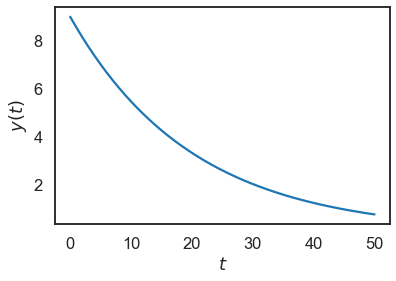

In [13]:
# Let's plot it:
fig, ax = plt.subplots()
ax.plot(solver.t, y)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

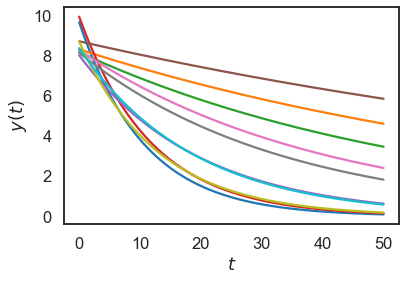

In [14]:
# Now, let's just plot a few random samples.
fig, ax = plt.subplots()
for i in range(10):
    x = np.random.rand(2)
    y = solver(x)
    plt.plot(solver.t, y)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$');

### Propagating Uncertainties with MC

Let's propagate the uncertainties through the ODE using MC.

In [15]:
# Let's now do Monte Carlo to compute the mean and the variance
# This is to accumulate the sum of all outputs
y_mc = np.zeros(solver.num_output)
# This is to accumlate the square of all outputs
y2_mc = np.zeros(solver.num_output)
# Pick the number of samples you wish to do:
num_samples = 10000
# Let's do it
data_mc = []
for i in range(num_samples):
    if i % 1000 == 0:
        print('sample', i + 1, 'from', num_samples)
    x = np.random.rand(2)
    y = solver(x)
    y_mc += y
    y2_mc += y ** 2
    data_mc.append(y)
data_mc = np.array(data_mc)
# Now we are ready for the mean estimate:
y_m_mc = y_mc / num_samples
# And the variance estimate
y_v_mc = y2_mc / num_samples - y_m_mc ** 2

sample 1 from 10000
sample 1001 from 10000
sample 2001 from 10000
sample 3001 from 10000
sample 4001 from 10000
sample 5001 from 10000
sample 6001 from 10000
sample 7001 from 10000
sample 8001 from 10000
sample 9001 from 10000


Text(0, 0.5, '$\\mathbb{E}[y(t)]$')

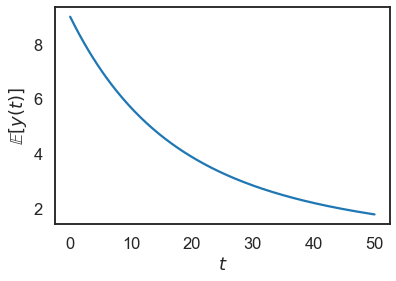

In [16]:
# Let's plot the mean
fig, ax = plt.subplots()
ax.plot(solver.t, y_m_mc)
ax.set_xlabel('$t$')
ax.set_ylabel('$\mathbb{E}[y(t)]$')

Text(0, 0.5, '$\\mathbb{V}[y(t)]$')

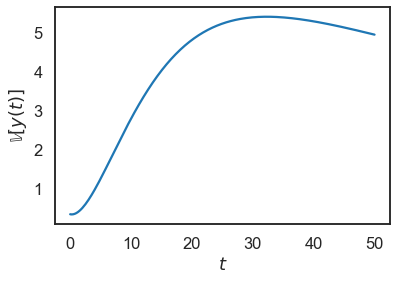

In [17]:
# Let's plot the variance
fig, ax = plt.subplots()
ax.plot(solver.t, y_v_mc)
ax.set_xlabel('$t$')
ax.set_ylabel('$\mathbb{V}[y(t)]$')

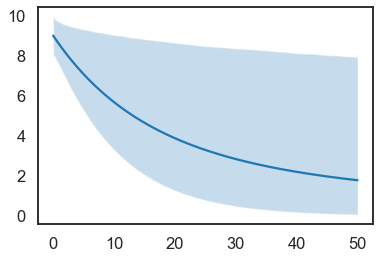

In [18]:
# Now, let's draw the predictive envelop
# We need the standard deviation:
y_s_mc = np.sqrt(y_v_mc)
# A lower bound for the prediction
y_l_mc = np.percentile(data_mc, 2.75, axis=0)
# An upper bound for the prediction
y_u_mc = np.percentile(data_mc, 97.5, axis=0)
# And let's plot it:
fig, ax = plt.subplots()
ax.plot(solver.t, y_m_mc)
ax.fill_between(solver.t, y_l_mc, y_u_mc, alpha=0.25)

### Propagating Uncertainties with LHS

Let's propagate the uncertainties through the ODE using LHS.
All we have to do is to copy and paste the above code and make some modifications.

In [19]:
# Let's now do LHS to compute the mean and the variance
# This is to accumulate the sum of all outputs
y_lhs = np.zeros(solver.num_output)
# This is to accumlate the square of all outputs
y2_lhs = np.zeros(solver.num_output)
# Pick the number of samples you wish to do:
num_samples = 10000
# You have to create the LHS design prior to looping:
X = pyDOE.lhs(2, num_samples)
# Let's do it
data_lhs = []
for i in range(num_samples):
    if i % 1000 == 0:
        print('sample', i + 1, 'from', num_samples)
    x = X[i, :]
    y = solver(x)
    y_lhs += y
    y2_lhs += y ** 2
    data_lhs.append(y)
data_lhs = np.array(data_lhs)
# Now we are ready for the mean estimate:
y_m_lhs = y_lhs / num_samples
# And the variance estimate
y_v_lhs = y2_lhs / num_samples - y_m_lhs ** 2

sample 1 from 10000
sample 1001 from 10000
sample 2001 from 10000
sample 3001 from 10000
sample 4001 from 10000
sample 5001 from 10000
sample 6001 from 10000
sample 7001 from 10000
sample 8001 from 10000
sample 9001 from 10000


Text(0, 0.5, '$\\mathbb{E}[y(t)]$')

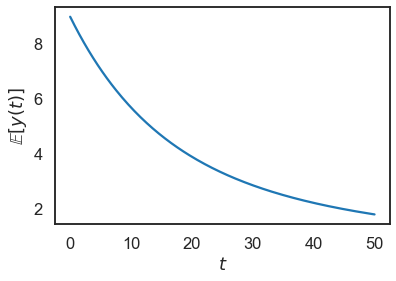

In [20]:
# Let's plot the mean
plt.plot(solver.t, y_m_lhs)
plt.xlabel('$t$')
plt.ylabel('$\mathbb{E}[y(t)]$')

Text(0, 0.5, '$\\mathbb{V}[y(t)]$')

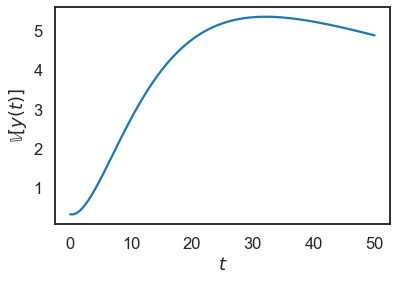

In [21]:
# Let's plot the variance
plt.plot(solver.t, y_v_lhs)
plt.xlabel('$t$')
plt.ylabel('$\mathbb{V}[y(t)]$')

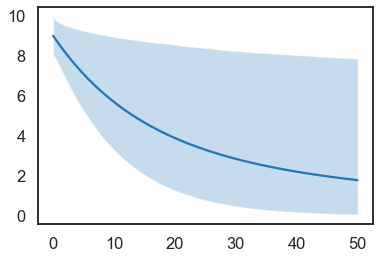

In [22]:
# Now, let's draw the predictive envelop
# We need the standard deviation:
y_s_lhs = np.sqrt(y_v_lhs)
y_l_lhs = np.percentile(data_lhs, 2.75, axis=0)
# An upper bound for the prediction
y_u_lhs = np.percentile(data_lhs, 97.5, axis=0)
# And let's plot it:
plt.plot(solver.t, y_m_lhs)
plt.fill_between(solver.t, y_l_lhs, y_u_lhs, alpha=0.25)

## Comparing MC to LHS

So, which one is better? MC or LHS? To test this, we need to establish a ground truth.
Fortunately, we can get an analytic solution to:
$$
\dot{y} = -0.1 x_1 y, y(0) = 8 + 2x_2.
$$
It is:
$$
y(t;x_1,x_2) = (8 + 2x_2)e^{-0.1 x_1 t}.
$$
We can integrate $x_1$ and $x_2$ analytically from this expression.

Doing so, we get the following mean solution and variance:
$$
\mu = \mathbb{E}[y] = \frac{90}{t} (1 - \exp^{-0.1t}), \\
\mathrm{S} = \mathbb{V}[y] =  \frac{2440}{6t}(1 - \exp^{-0.2t}) - \mu^2
$$

In [23]:
def E_y(t):
    if t == 0:
        return 9.
    return (90*(1-np.exp(-0.1*t))) / t
E_y =  np.vectorize(E_y)

def V_y(t):
    if t == 0:
        return (2440*0.2)/6. - E_y(t) **2
    
    return (2440.*(1-np.exp(-0.2*t)))/(6.*t) - E_y(t)**2
V_y = np.vectorize(V_y)

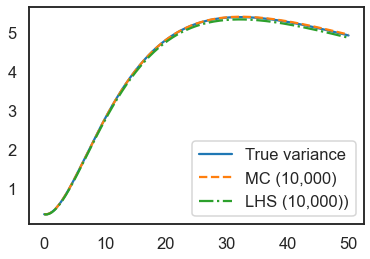

In [24]:
# Let's start by doing some plots that compare the variance obtained by MC and LHS to the true one
plt.plot(solver.t, V_y(solver.t), label='True variance')
plt.plot(solver.t, y_v_mc, '--', label='MC (10,000)')
plt.plot(solver.t, y_v_lhs, '-.', label='LHS (10,000))')
plt.legend(loc='best')

They seem close. But this is for 10,000 samples.
Let's test the convergence of each method. To do this, we will compute the evolution of the root square error in the variance:
$$
\text{RSE}_\alpha(n) = \left(\sum_{i=1}^{n_t}\left(V[y(t_i)] - V_{\alpha,n}[y(t_i)]\right)^2\right)^{\frac{1}{2}},
$$
where $\alpha = \{\text{MC}, \text{LHS}\}$ stands for the method, $n$ for the number of samples used, and $V_{\alpha,n}[y(t_i)]$ for the estimate of the variance of $y(t_i)$.
It will probably take a while to develop the code.

In [25]:
def get_MC_rse(max_num_samples=100):
    """
    Get the maximum error of MC.
    """
    y_v_true = V_y(solver.t)
    y = np.zeros(solver.num_output)
    y2 = np.zeros(solver.num_output)
    n = []
    rse = []
    for i in range(max_num_samples):
        x = np.random.rand(2)
        y_sample = solver(x)
        y += y_sample
        y2 += y_sample ** 2
        if i % 1 == 0:    # Produce estimate every 100 steps
            n.append(i + 1)
            y_m = y / (i + 1)
            y_v = y2 / (i + 1) - y_m ** 2
            rse.append(np.linalg.norm(y_v_true - y_v))
    return n, rse

def _get_LHS_rse(max_num_samples=100):
    y_v_true = V_y(solver.t)
    y = np.zeros(solver.num_output)
    y2 = np.zeros(solver.num_output)
    n = []
    rse = []
    X = pyDOE.lhs(2, num_samples)
    for i in range(max_num_samples):
        x = X[i, :]
        y_sample = solver(x)
        y += y_sample
        y2 += y_sample ** 2
        if i % 1 == 0:    # Produce estimate every 100 steps
            n.append(i + 1)
            y_m = y / (i + 1)
            y_v = y2 / (i + 1) - y_m ** 2
            rse.append(np.linalg.norm(y_v_true - y_v))
    return n, rse

def get_LHS_rse(max_num_samples=100):
    n = []
    rse = []
    for i in range(max_num_samples):
        if i % 1 == 0:
            _n, _rse = _get_LHS_rse(i + 1)
            n.append(_n[-1])
            rse.append(_rse[-1])
    return n, rse

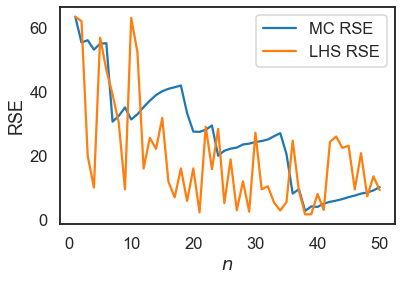

In [26]:
n_mc, rse_mc = get_MC_rse(50)
n_lhs, rse_lhs = get_LHS_rse(50)
plt.plot(n_mc, rse_mc, label='MC RSE')
plt.plot(n_lhs, rse_lhs, label='LHS RSE')
plt.xlabel('$n$')
plt.ylabel('RSE')
plt.legend(loc='best')

It is hard to tell which one is better...
There is a considerable ammount of epistemic uncertainty.
How would you go about quantifying it?
Notice, that everytime you run the above code, it produces a different estimate. This suggests, that if you repeat the procedure, say 100 times, you will be able to get predictive error bars for the error!

0


Text(0, 0.5, 'RSE')

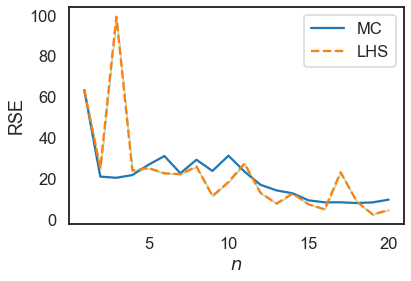

In [27]:
num_exper = 1
num_samples = 20
rse_mc_samples = []
rse_lhs_samples = []
for i in range(num_exper):
    print(i)
    n_mc, rse_mc = get_MC_rse(num_samples)
    n_lhs, rse_lhs = get_LHS_rse(num_samples)
    rse_mc_samples.append(rse_mc)
    rse_lhs_samples.append(rse_lhs)
rse_mc_samples = np.array(rse_mc_samples)
rse_lhs_samples = np.array(rse_lhs_samples)
rse_mc_m = np.mean(rse_mc_samples, axis=0)
rse_mc_l = np.percentile(rse_mc_samples, 2.75, axis=0)
rse_mc_u = np.percentile(rse_mc_samples, 97.5, axis=0)
rse_lhs_m = np.mean(rse_lhs_samples, axis=0)
rse_lhs_l = np.percentile(rse_lhs_samples, 2.75, axis=0)
rse_lhs_u = np.percentile(rse_lhs_samples, 97.5, axis=0)
plt.plot(n_mc, rse_mc_m, label='MC')
plt.plot(n_lhs, rse_lhs_m, '--', label='LHS')
plt.fill_between(n_mc, rse_mc_l, rse_mc_u, alpha=0.25)
plt.fill_between(n_lhs, rse_lhs_l, rse_lhs_u, color='g', alpha=0.25)
plt.legend(loc='best')
plt.xlabel('$n$')
plt.ylabel('RSE')

### Questions

+ To get a more accurate picture of the convergence rate of the two methods increaes the number of trials ``num_expr``. You will have to wait...

+ LHS seems to perform better. Does it have a different convergence rate than MC?